### Telemetry Hello World (v4 submissions)

This is a very a brief introduction to Spark and Telemetry in Python. You should have a look at the [tutorial](https://gist.github.com/vitillo/25a20b7c8685c0c82422) in Scala and the associated [talk](http://www.slideshare.net/RobertoAgostinoVitil/spark-meets-telemetry) if you are interested to learn more about Spark.
The goal of this example is to plot the startup distribution for each OS. 

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py

from moztelemetry import get_pings, get_pings_properties, get_one_ping_per_client

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Let's see how many parallel workers we have at our disposal:

In [2]:
sc.defaultParallelism

16

Let's fetch 10% of Telemetry submissions for a given build-id...

In [3]:
pings = get_pings(sc, app="Firefox", channel="nightly", submission_date="20150426", fraction=0.1, schema="v4")

... and exctract only the attributes we need from the Telemetry submissions:

In [4]:
subset = get_pings_properties(pings, ["clientId",
                                      "environment/system/os/name",
                                      "payload/simpleMeasurements/firstPaint"])

Let's filter out submissions with an invalid startup time:

In [5]:
subset = subset.filter(lambda p: p.get("payload/simpleMeasurements/firstPaint", -1) >= 0)

To prevent pseudoreplication, let's consider only a single submission for each client. As this step requires a distributed shuffle, it should always be run only after extracting the attributes of interest with *get_pings_properties*.

In [6]:
subset = get_one_ping_per_client(subset)

Caching is fundamental as it allows for an iterative, real-time development workflow:

In [7]:
cached = subset.cache()

How many pings are we looking at?

In [8]:
cached.count()

5341

Let's group the startup timings by OS:

In [9]:
grouped = cached.map(lambda p: (p["environment/system/os/name"], p["payload/simpleMeasurements/firstPaint"])).groupByKey().collectAsMap()

And finally plot the data:

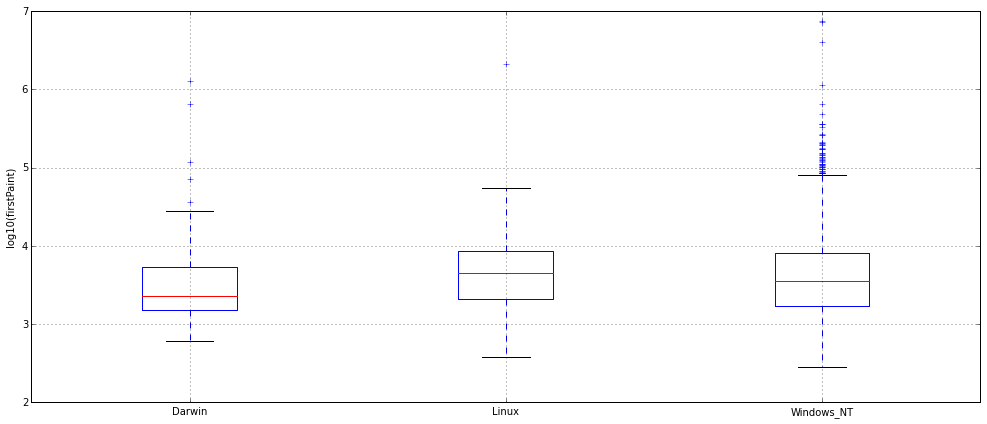

In [10]:
frame = pd.DataFrame({x: np.log10(pd.Series(list(y))) for x, y in grouped.items()})
plt.figure(figsize=(17, 7))
frame.boxplot(return_type="axes")
plt.ylabel("log10(firstPaint)")
plt.show()

You can also create interactive plots with [plotly](https://plot.ly/):

In [11]:
fig = plt.figure(figsize=(18, 7))
frame["Windows_NT"].plot(kind="hist", bins=50)
plt.title("startup distribution for Windows")
plt.ylabel("count")
plt.xlabel("log10(firstPaint)")
py.iplot_mpl(fig, strip_style=True)